# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


In [ ]:
# import os

# os.chdir("/content/drive/MyDrive/GAN_747")


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


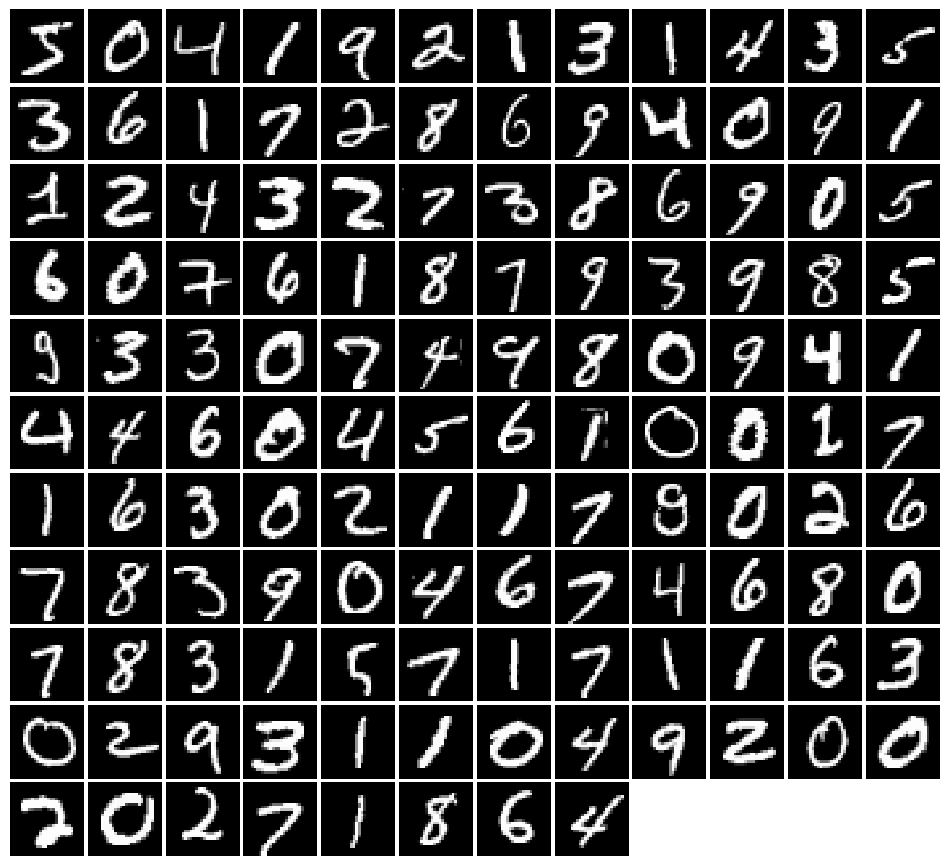

In [34]:
NOISE_DIM = 100
batch_size = 128
img_size = 28

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs_iter = loader_train.__iter__()
imgs = next(imgs_iter)[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [7]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [8]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.4935, G:0.6737


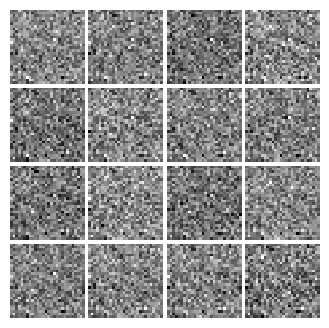


Iter: 250, D: 0.3816, G:0.8895


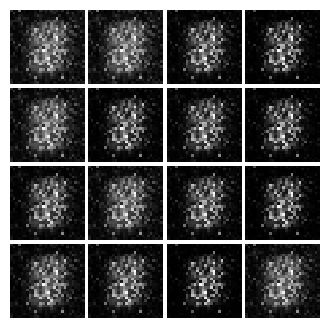


EPOCH:  2
Iter: 500, D: 0.2821, G:0.9468


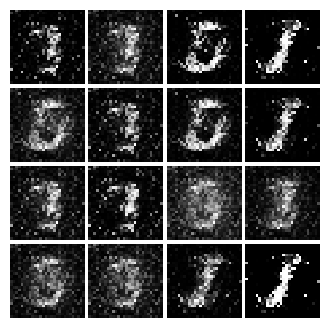


Iter: 750, D: 0.4218, G:0.6635


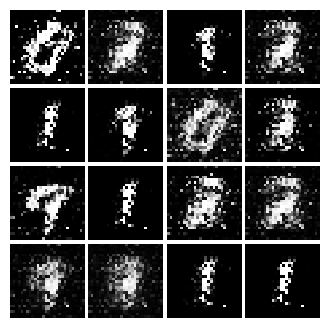


EPOCH:  3
Iter: 1000, D: 0.3291, G:1.36


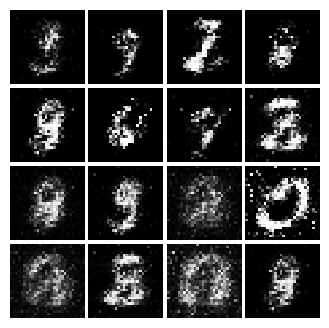


Iter: 1250, D: 0.3203, G:0.7184


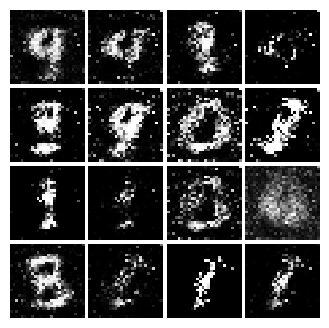


EPOCH:  4
Iter: 1500, D: 0.3954, G:0.5886


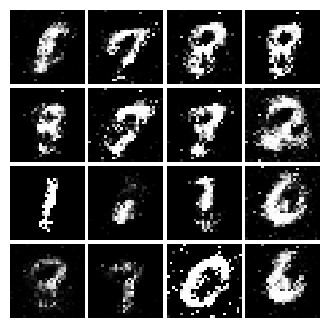


Iter: 1750, D: 0.4297, G:0.7561


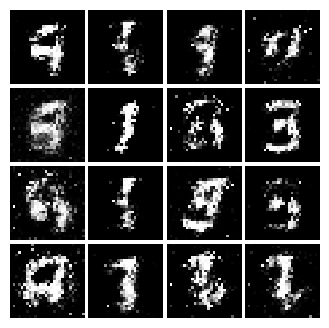


EPOCH:  5
Iter: 2000, D: 0.3889, G:0.7402


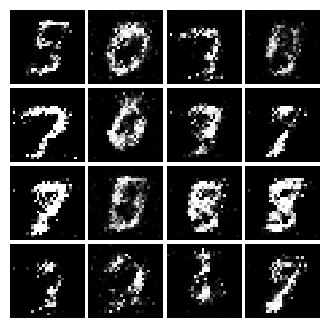


Iter: 2250, D: 0.4507, G:0.62


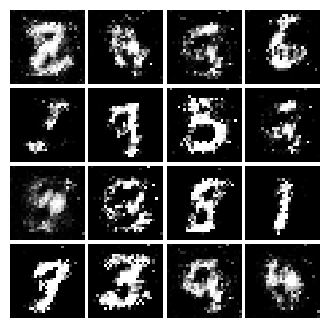


EPOCH:  6
Iter: 2500, D: 0.4623, G:0.5072


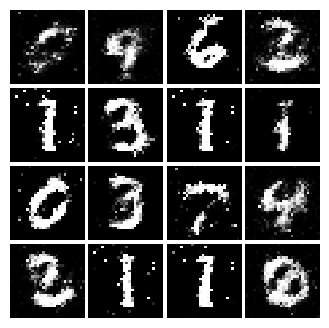


Iter: 2750, D: 0.4724, G:0.5786


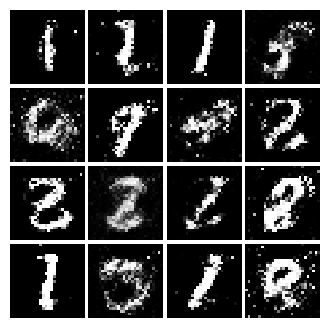


EPOCH:  7
Iter: 3000, D: 0.4229, G:0.5588


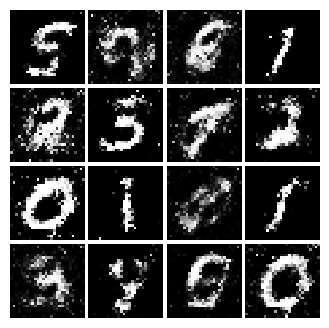


Iter: 3250, D: 0.4366, G:0.5786


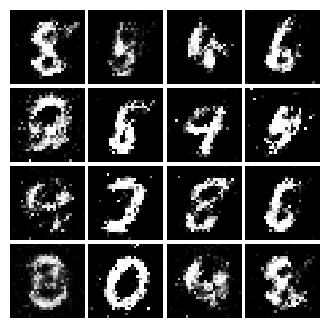


EPOCH:  8
Iter: 3500, D: 0.4485, G:0.6048


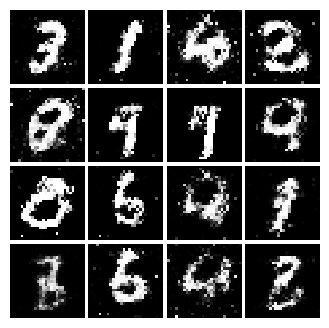


EPOCH:  9
Iter: 3750, D: 0.4591, G:0.6869


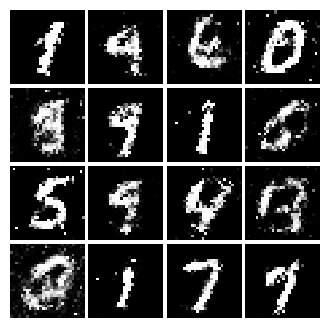


Iter: 4000, D: 0.4365, G:0.5725


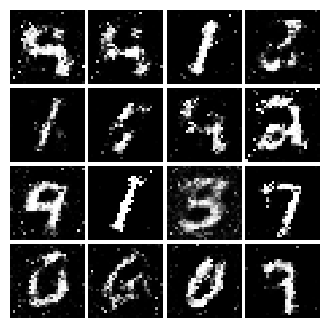


EPOCH:  10
Iter: 4250, D: 0.4346, G:0.5636


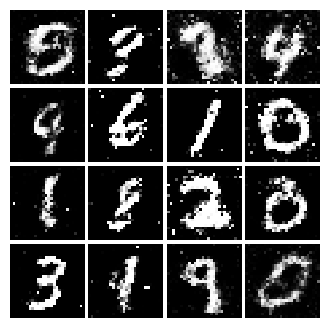


Iter: 4500, D: 0.4553, G:0.6058


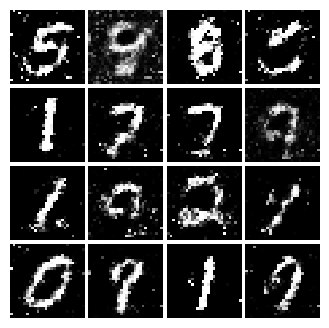

In [35]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device, img_resolution= img_size)

EPOCH:  1
Iter: 0, D: 0.5072, G:0.855


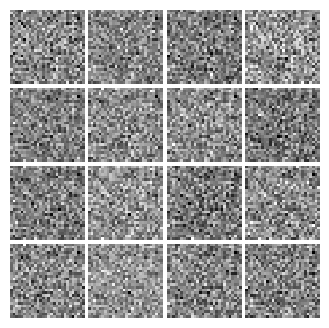


Iter: 250, D: 0.1762, G:0.5604


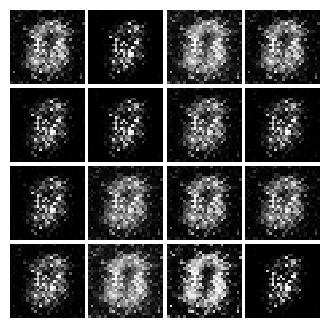


EPOCH:  2
Iter: 500, D: 0.09257, G:0.7389


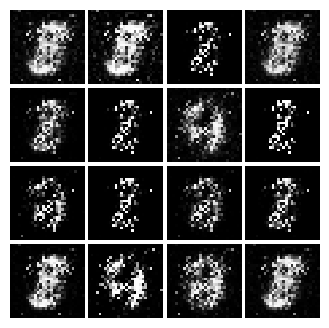


Iter: 750, D: 0.188, G:0.6012


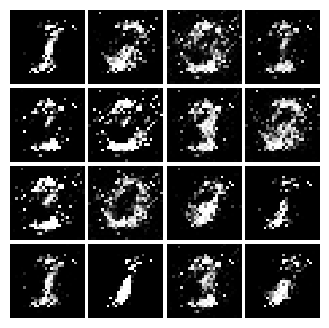


EPOCH:  3
Iter: 1000, D: 0.1687, G:0.5476


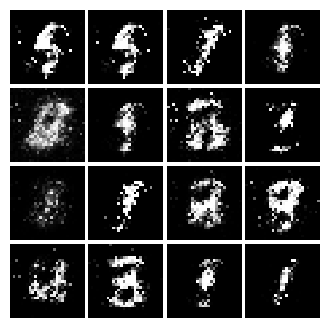


Iter: 1250, D: 0.1931, G:1.442


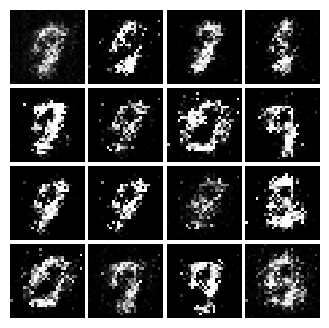


EPOCH:  4
Iter: 1500, D: 0.2315, G:0.5912


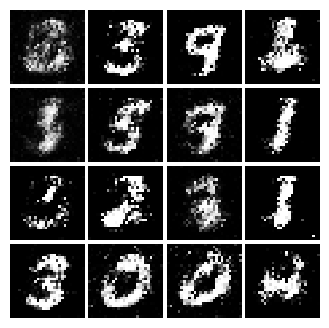


Iter: 1750, D: 0.1922, G:0.4536


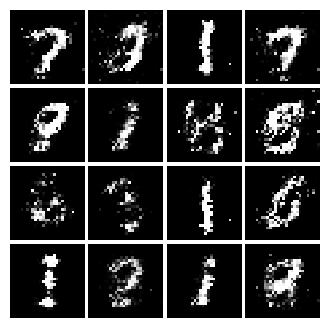


EPOCH:  5
Iter: 2000, D: 0.2072, G:0.4265


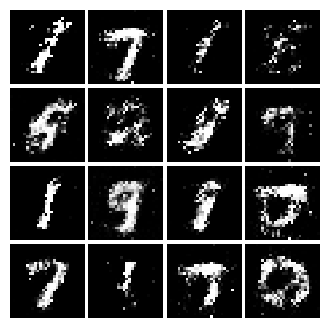


Iter: 2250, D: 0.2098, G:0.2762


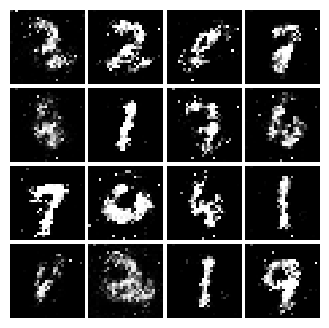


EPOCH:  6
Iter: 2500, D: 0.196, G:0.4165


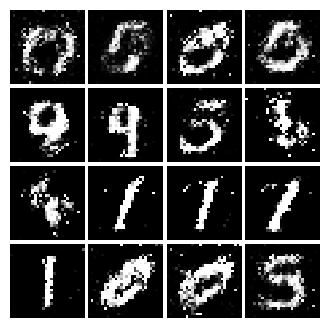


Iter: 2750, D: 0.2348, G:0.3618


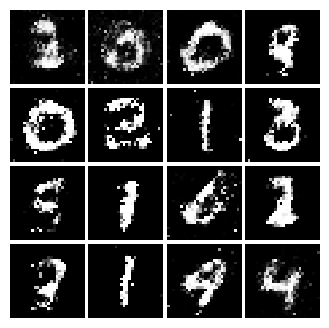


EPOCH:  7
Iter: 3000, D: 0.2179, G:0.3441


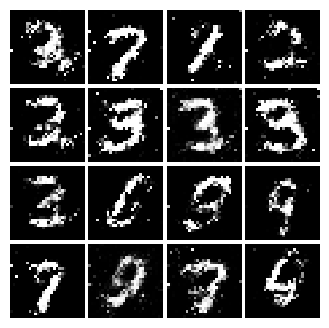


Iter: 3250, D: 0.2132, G:0.5198


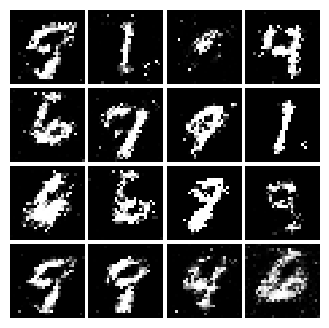


EPOCH:  8
Iter: 3500, D: 0.2362, G:0.3139


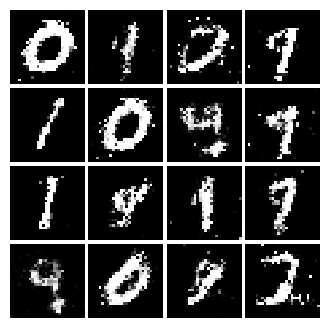


EPOCH:  9
Iter: 3750, D: 0.2013, G:0.3321


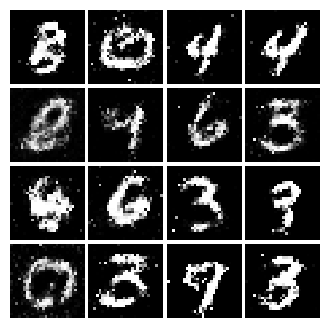


Iter: 4000, D: 0.2254, G:0.2795


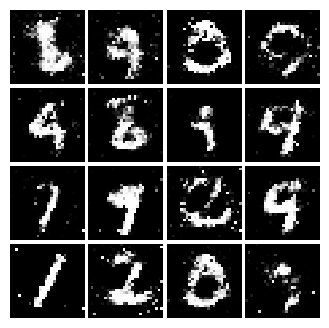


EPOCH:  10
Iter: 4250, D: 0.2282, G:0.3241


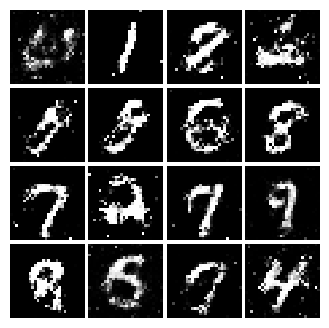


Iter: 4500, D: 0.2136, G:0.3618


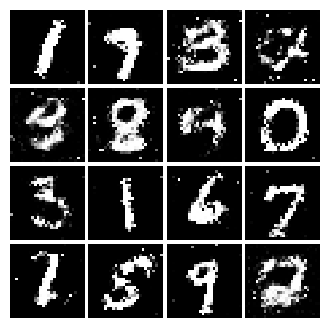

In [36]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device, img_resolution= img_size)